# Learning to Demap: Database Generation, Preprocessing, Postprocessing, Training, Validation and Inferences from the LLRNet


This notebook introduces the users to few functionalities provided by the [5G Toolkit](https://gigayasa.com/5g-toolkit/) such as

- PDSCH Transmitter Chain
- PDSCH Receiver
- Symbol Demapper. 

The PDSCH transmitter is compliant with 5G standards defined in [38.211](https://portal.3gpp.org/desktopmodules/Specifications/SpecificationDetails.aspx?specificationId=3213), [38.212](https://portal.3gpp.org/desktopmodules/Specifications/SpecificationDetails.aspx?specificationId=3214) and [38.214](https://portal.3gpp.org/desktopmodules/Specifications/SpecificationDetails.aspx?specificationId=3216). Finally, the tutorial will teach the user to replace one of the PDSCH receiver's module called Symbol Demapper with a neural network based Symbol Demapper [(**LLRNet**)](https://arxiv.org/pdf/1907.01512.pdf).


####################################################################################################

**Conventional Techniques**


~~~
- Log MAP Demapper
    - Optimal for AWGN Noise ==> Highest possible data rate | Lowest possible Block error rate
    - Complexity: Combinatorial ==> Consumes a lot of power
    - Not suitable for Internet of Things (**IoT**) devices.
- Max log MAP Demapper
    - Sub-Optimal performance ==> 3 dB loss in performance
    - Complexity: Linear ==> Consumes a less power compared to log-MAP
~~~

**Proposed Techniques**


~~~
- LLRNet
    - B(L)ER and Throughput Performance matches Log MAP Demapper
    - Complexity: Even lower than Max log MAP Demapper
~~~

####################################################################################################

Finally, the user will be able to rapidly evaluate and compare the


- Bit Error rate vs SNR
- Block Error rate vs SNR
- Throughput/Data rate vs SNR
- Computational Complexity
of Log-MAP, Max-Log-MAP and LLRNet methods.




## Table of Contents
* [Import Libraries](#Import-Libraries)
    * [Import Python Libraries](#Import-Python-Libraries)
    * [Import 5G Toolkit Modules](#Import-5G-Toolkit-Modules)
* [Learning to Demap the Symbols](#Learning-to-Demap-the-Symbols)
    * [Input Output Mapping for M = 4](#Input-Output-Mapping-for-M-=-4)
    * [Input Output Mapping for M = 6](#Input-Output-Mapping-for-M-=-6)
    * [Input Output Mapping for M = 8](#Input-Output-Mapping-for-M-=-8)
* [Throughput and BER Performance of LLRnet](#Throughput-and-BER-Performance-of-LLRnet)
    * [Import Libraries](#Import-Libraries)
    * [Simulation Parameters](#Simulation-Parameters)
    * [PDSCH Parameters](#PDSCH-Parameters)
    * [LLRnet Parameters](#LLRnet-Parameters)
        * [Training Framework](#Training-Framework)
        * [Deployment Framework](#Deployment-Framework)
* [Simulation Section](#Simulation-Section)
* [Performance Evaluation](#Performance-Evaluation)
    * [Throughput vs SNR (dB) for 16-QAM, 64-QAM and, 256-QAM](#Throughput-vs-SNR-(dB)-for-16-QAM,-64-QAM-and,-256-QAM)
	* [Bit Error rate (BER) vs SNR (dB) for 16-QAM, 64-QAM and, 256-QAM](#bit-error-rate-(BER)-vs-SNR-(dB)-for-16-QAM,-64-QAM-and,-256-QAM)
	* [Block Error Rate (BLER) vs SNR (dB) for 16-QAM, 64-QAM and, 256-QAM](#Block-Error-Rate-(BLER)-vs-SNR-(dB)-for-16-QAM,-64-QAM-and,-256-QAM)
* [Performance Evaluation: 10000 batches and 64000 training samples for LLRNet](#Performance-Evaluation:-10000-batches-and-64000-training-samples-for-LLRNet)
    * [Throughput vs SNR (dB) for 16-QAM, 64-QAM and, 256-QAM.](#Throughput-vs-SNR-(dB)-for-16-QAM,-64-QAM-and,-256-QAM.)
	* [Bit Error rate (BER) vs SNR (dB) for 16-QAM, 64-QAM and, 256-QAM.](#bit-error-rate-(BER)-vs-SNR-(dB)-for-16-QAM,-64-QAM-and,-256-QAM.)
	* [Block Error Rate (BLER) vs SNR (dB) for 16-QAM, 64-QAM and, 256-QAM.](#Block-Error-Rate-(BLER)-vs-SNR-(dB)-for-16-QAM,-64-QAM-and,-256-QAM.)
* [Complexity Analysis](#Complexity-Analysis)
* [Conclusion](#Conclusion)
* [References](#References:)




``Note``: The simulation might take upto 2-3 hour to complete for this projects because of 10 SNR points for each link, 3 modulation orders, 100 batches considered for simulation, and 3 methods to evaluate. Furthermore, simulation consumes 25-30 GB of RAM while simulation. To reduce the simulation time and memory consumption please excercise following options:

- Reduce batches to a lower number (``numFrames``)
- Reduce the number of SNR points (``numPoints``)
- Reduces the number of training samples (``numTrainingSamples``).


## Import Libraries

### Import Python Libraries 

In [1]:
# %matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy      as np
import tensorflow as tf

from tensorflow       import keras
from tensorflow.keras import layers

### Import 5G Toolkit Modules

* [LLRNet](llrNet.py)
* [Symbol Mapping](https://gigayasawireless.github.io/toolkit5G/api/5G_Toolkit/SymbolMapping/symbolMapping.mapper.html)
* [Symbol Demapping](https://gigayasawireless.github.io/toolkit5G/api/5G_Toolkit/SymbolMapping/symbolMapping.demapper.html)

In [2]:

from llrNet import LLRNet
from toolkit5G.SymbolMapping import Demapper
from toolkit5G.SymbolMapping import Mapper


In [3]:
# from IPython.display import display, HTML
# display(HTML("<style>.container { width:70% !important; }</style>"))

## Learning to Demap the Symbols
The Mapping between input and output is learned for a specific modulation order at a given SNR. The neural network model used for learning looks as follows:
![LLRNet](figures/nn1.svg)

The following inputs are expected for the experiments

* ``modOrder``: Defines the modulation order.
* ``nodesPerLayer``: Defines the number of nodes used for hidden layers. Number of nodes for input layer is 2 and number of nodes at the output layer is ``modOrder``. Number of hidden layers = np.size(nodesPerLayer).
* ``activationfunctions``: Defines the activation function used for each layer. Length should equal to np.size(``nodesPerLayer``) + 1. The last value defines the activation function for the output  layer.
* ``numTrainingSamples``: Defines the number of samples used for training the model.
* ``numTestSamples``: Defines the number of samples used for testing the performance of the model.
* ``SNR``: SNR value.

### Input Output Mapping for M = 4



************************************ Training the Model ***********************************
...........................................................................................


*********************************** Evaluating the Model **********************************
...........................................................................................
512/512 [==============================] - 0s 651us/step - loss: 1.0184e-04 - accuracy: 0.9938
Training Accuracy: 99.38
512/512 [==============================] - 0s 580us/step


************************************ Training the Model ***********************************
...........................................................................................


*********************************** Evaluating the Model **********************************
...........................................................................................
512/512 [==============================] - 0s 617us/step - loss: 4.5833e-04 - a

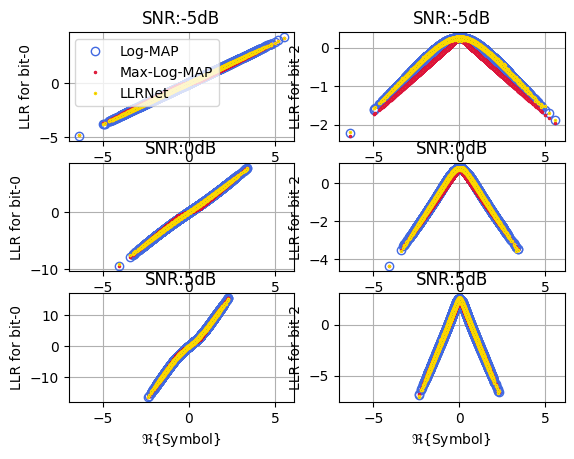

In [4]:
modOrder            = int(np.random.choice([2,4,6,8,10]))
nodesPerLayer       = np.array([32, 64, 32])
activationfunctions = np.array(['relu', 'relu', 'relu', 'linear'])
numTrainingSamples  = 2**8

llrNet = LLRNet(modOrder = modOrder, nodesPerLayer = nodesPerLayer, 
                numTrainingSamples = numTrainingSamples, activationfunctions = activationfunctions)

fig, ax = llrNet.displayMapping(modOrder = 4, bitLocations = [0,2], SNRdB = [-5,0,5], 
                                      numSamples = 2**16, displayRealPart = True)

### Input Output Mapping for M = 6



************************************ Training the Model ***********************************
...........................................................................................


*********************************** Evaluating the Model **********************************
...........................................................................................
4096/4096 [==============================] - 2s 585us/step - loss: 2.5838e-05 - accuracy: 0.9895
Training Accuracy: 98.95
4096/4096 [==============================] - 2s 525us/step


************************************ Training the Model ***********************************
...........................................................................................


*********************************** Evaluating the Model **********************************
...........................................................................................
4096/4096 [==============================] - 2s 579us/step - loss: 2.0524e-

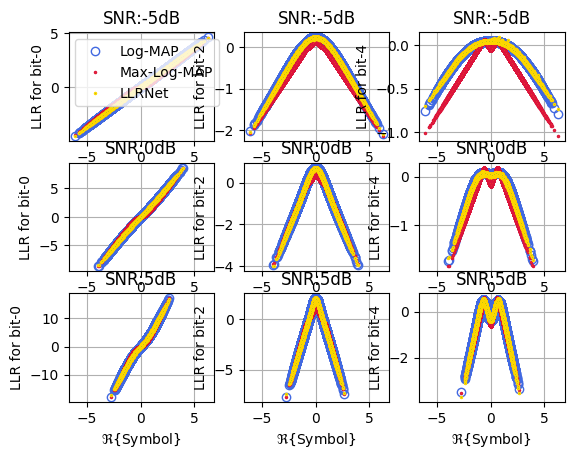

In [5]:
modOrder            = int(np.random.choice([2,4,6,8,10]))
nodesPerLayer       = np.array([32, 64, 32])
activationfunctions = np.array(['relu', 'relu', 'relu', 'linear'])
numTrainingSamples  = 2**16
SNR                 = 10

llrNet = LLRNet(modOrder = modOrder, nodesPerLayer = nodesPerLayer, 
                numTrainingSamples = numTrainingSamples, activationfunctions = activationfunctions)

fig, ax = llrNet.displayMapping(modOrder = 6, bitLocations = [0,2,4], SNRdB = [-5,0,5], 
                                      numSamples = 3*2**18, displayRealPart = True)

### Input Output Mapping for M = 8

In [6]:
modOrder            = int(np.random.choice([2,4,6,8,10]))
nodesPerLayer       = np.array([32, 64, 32])
activationfunctions = np.array(['relu', 'relu', 'relu', 'linear'])
numTrainingSamples  = 2**16
SNR                 = 10

llrNet  = LLRNet(modOrder = modOrder, nodesPerLayer = nodesPerLayer,
                 numTrainingSamples  = numTrainingSamples, 
                 activationfunctions = activationfunctions)

fig, ax = llrNet.displayMapping(modOrder = 8, bitLocations = [0,2,4,6], SNRdB = [-5,0,5], 
                                      numSamples = 2**20, displayRealPart = True)



************************************ Training the Model ***********************************
...........................................................................................


*********************************** Evaluating the Model **********************************
...........................................................................................
4096/4096 [==============================] - 2s 591us/step - loss: 1.0649e-05 - accuracy: 0.9734
Training Accuracy: 97.34
4096/4096 [==============================] - 2s 528us/step


************************************ Training the Model ***********************************
...........................................................................................


*********************************** Evaluating the Model **********************************
...........................................................................................
4096/4096 [==============================] - 3s 611us/step - loss: 5.3079e-

## Throughput and BER Performance of *LLRnet*
### Import Libraries

In [7]:
from toolkit5G.PhysicalChannels.PDSCH import ComputeTransportBlockSize
from toolkit5G.PhysicalChannels       import PDSCHLowerPhy
from toolkit5G.PhysicalChannels       import PDSCHDecoderLowerPhy
from toolkit5G.PhysicalChannels       import PDSCHUpperPhy
from toolkit5G.PhysicalChannels       import PDSCHDecoderUpperPhy
from toolkit5G.Configurations         import TimeFrequency5GParameters
from toolkit5G.ChannelProcessing      import AddNoise

### Simulation Parameters
|Parameters | Variable | Values
| :--- | :--- | :---
|Number of frames | ``numFrames`` | 200
|Subcarrier Spacing | ``scSpacing`` | 30 KHz
|Bandwidth | ``Bandwidth`` | 20 MHz
|Number of Resource Blocks | ``numRBs`` | 51
|Number of Transmit Antennas | ``numTx`` | 8
|Number of Receive Antennas | ``numRx`` | 2
|Number of layers | ``numLayers`` | 2
|Physical Channel | ``PDSCH`` | Simulation are carried out for **Physical Downlink Shared Channel** (PDSCH)
|Channel Coder | ``LDPC`` | PDSCH uses Low density parity check codes internally
|Code rate | ``codeRate`` | 0.4785
|Modulation Order | ``modOrder`` | 16-QAM, 64-QAM, 256--QAM

In [8]:
# Simulation Parameters
numBSs       = 1
numUEs       = 1
numFrames    = 100
scSpacing    = 30000
Bandwidth    = 20*10**6
nSymbolFrame = 140*int(scSpacing/15000);   # Number of OFDM symbols per frame (Its a function of subcarrier spacing)
slotDuration = 0.001/(scSpacing/15000)

tfParams     = TimeFrequency5GParameters(Bandwidth, scSpacing)
tfParams(nSymbolFrame, typeCP = "normal")
numRBs    = tfParams.numRBs

#  Antenna and Precoding Parameters
numTx     = 8
numRx     = 2
numLayers = 2

### PDSCH Parameters

In [9]:
# Set start symbol and number of symbols for DMRS transmission.
startSymbol  = 0
numSymbols   = 13
dmrsREs      = 0
scalingField = '00'

# Modulation and Coding Rate Parameters
codeRate     = 0.4785
modOrders    = [4, 6, 8]  ## For 16-QAM, 64-QAM and 256-QAM
numLayers    = 2
numTBs       = 1
additionalOverhead = 0

print("************ PDSCH Parameters *************")
print()
print("        startSymbol: "+str(startSymbol))
print("         numSymbols: "+str(numSymbols))
print("            dmrsREs: "+str(dmrsREs))
print("       scalingField: "+str(scalingField))
print("           modOrder: "+str(modOrders))
print("           codeRate: "+str(codeRate))
print("          numLayers: "+str(numLayers))
print("             numTBs: "+str(numTBs))
print(" additionalOverhead: "+str(additionalOverhead))
print()
print("********************************************")

enableLBRM = False # Flag to enable/disbale "Limited buffer rate matching"
rvid1      = 0     # Redundency version-ID for TB-1: As per 3GPP TS38.212
rvid2      = 0     # Redundency version-ID for TB-2: As per 3GPP TS38.212

************ PDSCH Parameters *************

        startSymbol: 0
         numSymbols: 13
            dmrsREs: 0
       scalingField: 00
           modOrder: [4, 6, 8]
           codeRate: 0.4785
          numLayers: 2
             numTBs: 1
 additionalOverhead: 0

********************************************


### LLRnet Parameters
#### Training Framework

* The artificial neural network (ANN) is trained to mimic a optimal method with lower complexity.
* The input to ANN model and optimal log-MAP method is the estimated equalized symbol and the output of the log-MAP method is fed to ANN output for learning the model parameters using adaptive moment estimation (ADAM) optimizer while Levenberg-Marquardt backpropagation.
* We are assuming ``epochs`` = 4, ``batch_size`` = 32 for reasonable complexing while training.
* **Note:** We are assuming slighly large neural networks compared to what paper claims. As we were unable to reproduce the exact same results.

![training](figures/LLRNetNew.png)

#### Deployment Framework

* The trained model is used to predict the llr for each bits for the received symbols.
* The received symbol is represented using the its real and imaginary part and fed to the model.
* The ANN model emits ``M``-llr estimates one for each bit. 

![training](figures/LLRNetDeployment.png)

In [10]:
nodesPerLayer       = np.array([32, 64, 32])
activationfunctions = np.array(['relu', 'relu', 'relu', 'linear'])
numTrainingSamples  = 3*2**14

## Simulation Section
The simulation is carried out for 3 modulation orders 16-QAM (M=4), 64-QAM (M=6), and 256-QAM (M=8). 

* For **M = 4**:
    * The simulation is carried out for SNR (dB) in the range ().
* For **M = 6**:
    * The simulation is carried out for SNR (dB) in the range ().
* For **M = 8**:
    * The simulation is carried out for SNR (dB) in the range ().

In [11]:
modOrders  = np.array([4, 6, 8])       ## For 16-QAM, 64-QAM and 256-QAM
numPoints  = 10
SNRdB      = np.array([np.linspace(5.4,   6.4, numPoints),
                       np.linspace(9.5,  10.8, numPoints),
                       np.linspace(13.4, 14.4, numPoints)])

BER        = np.zeros((3, modOrders.size, SNRdB.shape[-1]))
BLER       = np.zeros((3, modOrders.size, SNRdB.shape[-1]))
Throughput = np.zeros((3, modOrders.size, SNRdB.shape[-1]))
SNR        = 10**(0.1*SNRdB)

maxThroughput = (14*numRBs*12*modOrders*numLayers*codeRate)/slotDuration
mcsIdx = 0
for modorder in modOrders:

    ## PDSCH-transmitter chain object
    pdschUpPhy = PDSCHUpperPhy(numTBs = numTBs, mcsIndex = np.array([modorder, codeRate]),
                               symbolsPerSlot = numSymbols, numRB  = numRBs,
                               numlayers = [numLayers], scalingField = scalingField,
                               additionalOverhead = additionalOverhead, dmrsREs = dmrsREs,
                               pdschTable = None, verbose=False)
    
    codewords  = pdschUpPhy(rvid = [rvid1, rvid2], enableLBRM = [False, False],
                            numBatch = numFrames, numBSs = numBSs)

    symbols    = Mapper("qam", pdschUpPhy.modOrder)(codewords[0])

    snrIndex   = 0
    for snr in SNR[mcsIdx]:

        # log-MAP Decoder
        rxSymbols = np.complex64(AddNoise()(symbols, 1/snr))
        llrs      = Demapper("app", "qam", int(modorder), hard_out = False)([rxSymbols, np.float32(1/snr)])
        # Receiver: Upper Physical layer
#         pdschDecoderUpperPhy  = PDSCHDecoderUpperPhy(numTBs, [modorder, codeRate], numSymbols, 
#                                                      numRBs, [numLayers], scalingField,
#                                                      [rvid1], additionalOverhead, dmrsREs, 
#                                                      pdschTable = None, verbose=False)
        
        pdschDecoderUpperPhy  = PDSCHDecoderUpperPhy(numTBs, np.array([modorder, codeRate]), numSymbols, 
                                                     numRBs, [numLayers], scalingField, 
                                                     additionalOverhead, dmrsREs, 
                                                     enableLBRM=[False, False], pdschTable=None, 
                                                     rvid=[rvid1], verbose=False)
        
        tbEst     = pdschDecoderUpperPhy([llrs])

        BER[0, mcsIdx, snrIndex]        = np.mean(np.abs(tbEst[0] - pdschUpPhy.tblock1))
        if (pdschDecoderUpperPhy.numCBs == 1):
            BLER[0, mcsIdx, snrIndex]   = 1 - np.mean(pdschDecoderUpperPhy.crcCheckTBs)
        else:
            BLER[0, mcsIdx, snrIndex]   = 1 - np.mean(pdschDecoderUpperPhy.crcCheckforCBs)
        Throughput[0, mcsIdx, snrIndex] = (1-BLER[0, mcsIdx, snrIndex])*pdschUpPhy.tblock1.shape[-1]/slotDuration
        print() 
        print("+++++++++++ [ snrIndex: "+str(snrIndex)+" | modorder: "+str(modorder)+"] +++++++++++")
        print("===================================================")
        print("     **************** log-MAP ****************     ")
        print("mod-Order: "+str(modorder)+" | SNR (dB): "+str(SNRdB[mcsIdx, snrIndex]))
        print("        BER: "+str(BER[0, mcsIdx, snrIndex]))
        print("       BLER: "+str(BLER[0, mcsIdx, snrIndex]))
        print(" Throughput: "+str(Throughput[0, mcsIdx, snrIndex]))
        print(".......................................................")

        # max-log-MAP Decoder
        llrs      = Demapper("maxlog", "qam", int(modorder), hard_out = False)([rxSymbols, np.float32(1/snr)])
        
        pdschDecoderUpperPhy  = PDSCHDecoderUpperPhy(numTBs, np.array([modorder, codeRate]), numSymbols, 
                                                     numRBs, [numLayers], scalingField, 
                                                     additionalOverhead, dmrsREs, 
                                                     enableLBRM=[False, False], pdschTable=None, 
                                                     rvid=[rvid1], verbose=False)
        
        tbEst     = pdschDecoderUpperPhy([llrs])

        BER[1, mcsIdx, snrIndex]        = np.mean(np.abs(tbEst[0] - pdschUpPhy.tblock1))
        if (pdschDecoderUpperPhy.numCBs == 1):
            BLER[1, mcsIdx, snrIndex]   = 1 - np.mean(pdschDecoderUpperPhy.crcCheckTBs)
        else:
            BLER[1, mcsIdx, snrIndex]   = 1 - np.mean(pdschDecoderUpperPhy.crcCheckforCBs)
        Throughput[1, mcsIdx, snrIndex] = (1-BLER[1, mcsIdx, snrIndex])*pdschUpPhy.tblock1.shape[-1]/slotDuration
        print("     **************** max-log-MAP ****************     ")
        print("mod-Order: "+str(modorder)+" | SNR (dB): "+str(SNRdB[mcsIdx, snrIndex]))
        print("        BER: "+str(BER[1, mcsIdx, snrIndex]))
        print("       BLER: "+str(BLER[1, mcsIdx, snrIndex]))
        print(" Throughput: "+str(Throughput[1, mcsIdx, snrIndex]))
        print(".......................................................")


        llrNet = LLRNet(modOrder = int(modorder), nodesPerLayer = nodesPerLayer, 
                        numTrainingSamples = numTrainingSamples, activationfunctions = activationfunctions)

        llrs   = llrNet(snr, rxSymbols)
        # Receiver: Upper Physical layer

        pdschDecoderUpperPhy  = PDSCHDecoderUpperPhy(numTBs, np.array([modorder, codeRate]), numSymbols, 
                                                     numRBs, [numLayers], scalingField, 
                                                     additionalOverhead, dmrsREs, 
                                                     enableLBRM=[False, False], pdschTable=None, 
                                                     rvid=[rvid1], verbose=False)
        
        tbEst   = pdschDecoderUpperPhy([llrs])

        BER[2, mcsIdx, snrIndex]        = np.mean(np.abs(tbEst[0] - pdschUpPhy.tblock1))
        if (pdschDecoderUpperPhy.numCBs == 1):
            BLER[2, mcsIdx, snrIndex]   = 1 - np.mean(pdschDecoderUpperPhy.crcCheckTBs)
        else:
            BLER[2, mcsIdx, snrIndex]   = 1 - np.mean(pdschDecoderUpperPhy.crcCheckforCBs)

        Throughput[2, mcsIdx, snrIndex] = (1-BLER[2, mcsIdx, snrIndex])*pdschUpPhy.tblock1.shape[-1]/slotDuration
        print("     ******************* LLRnet ******************     ")
        print("mod-Order: "+str(modorder)+" | SNR (dB): "+str(SNRdB[mcsIdx, snrIndex]))
        print("        BER: "+str(BER[2, mcsIdx, snrIndex]))
        print("       BLER: "+str(BLER[2, mcsIdx, snrIndex]))
        print(" Throughput: "+str(Throughput[2, mcsIdx, snrIndex]))
        print("_______________________________________________________") 
        print()
        snrIndex += 1

    mcsIdx += 1




+++++++++++ [ snrIndex: 0 | modorder: 4] +++++++++++
     **************** log-MAP ****************     
mod-Order: 4 | SNR (dB): 5.4
        BER: 0.025147934868943605
       BLER: 1.0
 Throughput: 0.0
.......................................................
     **************** max-log-MAP ****************     
mod-Order: 4 | SNR (dB): 5.4
        BER: 0.028224781572676726
       BLER: 1.0
 Throughput: 0.0
.......................................................


************************************ Training the Model ***********************************
...........................................................................................
Epoch 1/4
1536/1536 [==============================] - 2s 776us/step - loss: 0.7875 - accuracy: 0.9571
Epoch 2/4
1536/1536 [==============================] - 1s 767us/step - loss: 0.0052 - accuracy: 0.9923
Epoch 3/4
1536/1536 [==============================] - 1s 761us/step - loss: 0.0027 - accuracy: 0.9948
Epoch 4/4
1536/1536 [===============

     **************** max-log-MAP ****************     
mod-Order: 4 | SNR (dB): 6.4
        BER: 0.0
       BLER: 0.0
 Throughput: 60432000.0
.......................................................


************************************ Training the Model ***********************************
...........................................................................................
Epoch 1/4
1536/1536 [==============================] - 2s 916us/step - loss: 1.2061 - accuracy: 0.9545
Epoch 2/4
1536/1536 [==============================] - 1s 900us/step - loss: 0.0070 - accuracy: 0.9918
Epoch 3/4
1536/1536 [==============================] - 1s 904us/step - loss: 0.0028 - accuracy: 0.9948
Epoch 4/4
1536/1536 [==============================] - 1s 935us/step - loss: 0.0021 - accuracy: 0.9959


*********************************** Evaluating the Model **********************************
...........................................................................................
1536/1536 [======


+++++++++++ [ snrIndex: 4 | modorder: 6] +++++++++++
     **************** log-MAP ****************     
mod-Order: 6 | SNR (dB): 10.077777777777778
        BER: 0.0009125021690091967
       BLER: 0.405
 Throughput: 54863759.99999999
.......................................................
     **************** max-log-MAP ****************     
mod-Order: 6 | SNR (dB): 10.077777777777778
        BER: 0.0024898056567759846
       BLER: 0.685
 Throughput: 29045519.999999996
.......................................................


************************************ Training the Model ***********************************
...........................................................................................
Epoch 1/4
1536/1536 [==============================] - 2s 889us/step - loss: 3.4978 - accuracy: 0.8656
Epoch 2/4
1536/1536 [==============================] - 1s 848us/step - loss: 0.1237 - accuracy: 0.9658
Epoch 3/4
1536/1536 [==============================] - 1s 858us/step - loss



************************************ Training the Model ***********************************
...........................................................................................
Epoch 1/4
1536/1536 [==============================] - 2s 907us/step - loss: 12.4401 - accuracy: 0.8270
Epoch 2/4
1536/1536 [==============================] - 1s 875us/step - loss: 0.8994 - accuracy: 0.9237
Epoch 3/4
1536/1536 [==============================] - 1s 859us/step - loss: 0.3270 - accuracy: 0.9573
Epoch 4/4
1536/1536 [==============================] - 1s 900us/step - loss: 0.2392 - accuracy: 0.9637


*********************************** Evaluating the Model **********************************
...........................................................................................
1536/1536 [==============================] - 1s 624us/step - loss: 0.2117 - accuracy: 0.9664
Training Accuracy: 96.64
49725/49725 [==============================] - 28s 560us/step
     ******************* LLRnet ***


+++++++++++ [ snrIndex: 8 | modorder: 8] +++++++++++
     **************** log-MAP ****************     
mod-Order: 8 | SNR (dB): 14.28888888888889
        BER: 0.0
       BLER: 0.0
 Throughput: 120912000.0
.......................................................
     **************** max-log-MAP ****************     
mod-Order: 8 | SNR (dB): 14.28888888888889
        BER: 0.0
       BLER: 0.0
 Throughput: 120912000.0
.......................................................


************************************ Training the Model ***********************************
...........................................................................................
Epoch 1/4
1536/1536 [==============================] - 2s 1ms/step - loss: 15.8219 - accuracy: 0.8436
Epoch 2/4
1536/1536 [==============================] - 1s 910us/step - loss: 0.9824 - accuracy: 0.9256
Epoch 3/4
1536/1536 [==============================] - 1s 940us/step - loss: 0.4170 - accuracy: 0.9586
Epoch 4/4
1536/1536 [=======

## Performance Evaluation
### Throughput vs SNR (dB) for 16-QAM, 64-QAM and, 256-QAM

In [12]:
fig, ax = plt.subplots(1,3, figsize = (10,4))

# For 16-QAM
#********************************************
ax[0].plot(SNRdB[0], Throughput[0,0]/10**6, 'mediumspringgreen', lw = 4, linestyle = "solid", marker = "*", ms = 12, mec = "crimson", mfc = "darkblue", label = "log-MAP")
ax[0].plot(SNRdB[0], Throughput[2,0]/10**6, 'k', lw = 3, linestyle = (0, (3, 1, 1, 1, 1, 1)), marker = "X", ms = 9, mec = "green", mfc = "olive", label = "LLRnet")
ax[0].plot(SNRdB[0], Throughput[1,0]/10**6, 'tomato', lw = 3.5, linestyle = "dotted", marker = "s", ms = 6, mec = "k", mfc = "cyan", label = "max-log-MAP")

ax[0].legend(loc="lower right")
ax[0].set_xlabel("SNR [dB]", fontsize = 9)
ax[0].set_ylabel("Throughput (Mbps)", fontsize = 9)
ax[0].set_title("Throughput vs SNR(dB)", fontsize = 12)
ax[0].set_ylim(0, maxThroughput[2]/10**6)
ax[0].set_xticks(SNRdB[0])
ax[0].grid()

# For 64-QAM
#********************************************
ax[1].plot(SNRdB[1], Throughput[0,1]/10**6, 'mediumspringgreen', lw = 4, linestyle = "solid", marker = "*", ms = 12, mec = "crimson", mfc = "darkblue", label = "log-MAP")
ax[1].plot(SNRdB[1], Throughput[2,1]/10**6, 'k', lw = 3, linestyle = (0, (3, 1, 1, 1, 1, 1)), marker = "X", ms = 9, mec = "green", mfc = "olive", label = "LLRnet")
ax[1].plot(SNRdB[1], Throughput[1,1]/10**6, 'tomato', lw = 3.5, linestyle = "dotted", marker = "s", ms = 6, mec = "k", mfc = "cyan", label = "max-log-MAP")

ax[1].legend(loc="lower right")
ax[1].set_xlabel("SNR [dB]", fontsize = 9)
ax[1].set_title("Throughput vs SNR(dB)", fontsize = 12)
ax[1].set_ylim(0, maxThroughput[2]/10**6)
ax[1].set_xticks(SNRdB[1])
ax[1].grid()


# For 256-QAM
#********************************************

ax[2].plot(SNRdB[2], Throughput[0,2]/10**6, 'mediumspringgreen', lw = 4, linestyle = "solid", marker = "*", ms = 12, mec = "crimson", mfc = "darkblue", label = "log-MAP")
ax[2].plot(SNRdB[2], Throughput[2,2]/10**6, 'k', lw = 3, linestyle = (0, (3, 1, 1, 1, 1, 1)), marker = "X", ms = 9, mec = "green", mfc = "olive", label = "LLRnet")
ax[2].plot(SNRdB[2], Throughput[1,2]/10**6, 'tomato', lw = 3.5, linestyle = "dotted", marker = "s", ms = 6, mec = "k", mfc = "cyan", label = "max-log-MAP")

ax[2].legend(loc="lower right")
ax[2].set_xlabel("SNR [dB]", fontsize = 9)
ax[2].set_ylim(0, maxThroughput[2]/10**6)
ax[2].set_xticks(SNRdB[2])

# Adding Twin Axes to plot using dataset_2
axr = ax[2].twinx()
axr.set_ylabel('Throughput [%]')
# axr.plot(x, dataset_2, color = color)
axr.set_ylim(0, 100)
ax[2].grid()

plt.show()

### Bit Error rate (BER) vs SNR (dB) for 16-QAM, 64-QAM and, 256-QAM

* Comparison with:
    * max-log-MAP
    * log-MAP


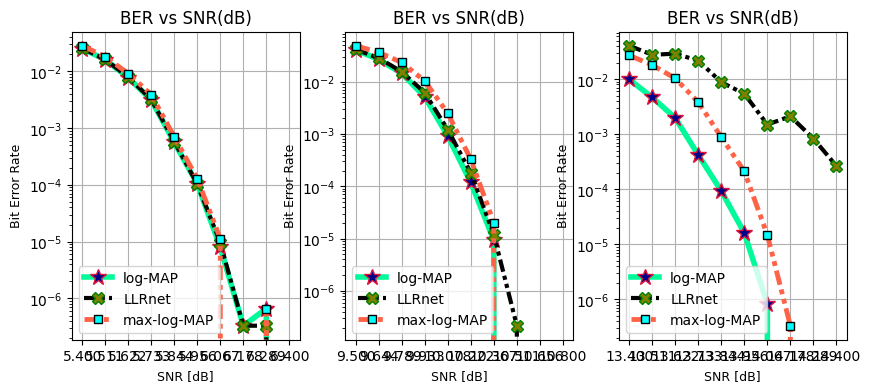

In [13]:
fig, ax = plt.subplots(1,3, figsize = (10,4))

# BER for QAM-16
ax[0].semilogy(SNRdB[0], BER[0,0], 'mediumspringgreen', lw = 4, linestyle = "solid", marker = "*", ms = 12, mec = "crimson", mfc = "darkblue", label = "log-MAP")
ax[0].semilogy(SNRdB[0], BER[2,0], 'k', lw = 3, linestyle = (0, (3, 1, 1, 1, 1, 1)), marker = "X", ms = 9, mec = "green", mfc = "olive", label = "LLRnet")
ax[0].semilogy(SNRdB[0], BER[1,0], 'tomato', lw = 3.5, linestyle = (0, (3, 1, 1, 1, 1, 1)), marker = "s", ms = 6, mec = "k", mfc = "cyan", label = "max-log-MAP")

ax[0].legend(loc="lower left")
ax[0].set_xlabel("SNR [dB]", fontsize = 9)
ax[0].set_ylabel("Bit Error Rate", fontsize = 9)
ax[0].set_title("BER vs SNR(dB)", fontsize = 12)
ax[0].set_xticks(SNRdB[0])
ax[0].grid()

# BER for QAM-64
ax[1].semilogy(SNRdB[1], BER[0,1], 'mediumspringgreen', lw = 4, linestyle = "solid", marker = "*", ms = 12, mec = "crimson", mfc = "darkblue", label = "log-MAP")
ax[1].semilogy(SNRdB[1], BER[2,1], 'k', lw = 3, linestyle = (0, (3, 1, 1, 1, 1, 1)), marker = "X", ms = 9, mec = "green", mfc = "olive", label = "LLRnet")
ax[1].semilogy(SNRdB[1], BER[1,1], 'tomato', lw = 3.5, linestyle = (0, (3, 1, 1, 1, 1, 1)), marker = "s", ms = 6, mec = "k", mfc = "cyan", label = "max-log-MAP")

ax[1].legend(loc="lower left")
ax[1].set_xlabel("SNR [dB]", fontsize = 9)
ax[1].set_ylabel("Bit Error Rate", fontsize = 9)
ax[1].set_title("BER vs SNR(dB)", fontsize = 12)
ax[1].set_xticks(SNRdB[1])
ax[1].grid()

# BER for QAM-256
ax[2].semilogy(SNRdB[2], BER[0,2], 'mediumspringgreen', lw = 4, linestyle = "solid", marker = "*", ms = 12, mec = "crimson", mfc = "darkblue", label = "log-MAP")
ax[2].semilogy(SNRdB[2], BER[2,2], 'k', lw = 3, linestyle = (0, (3, 1, 1, 1, 1, 1)), marker = "X", ms = 9, mec = "green", mfc = "olive", label = "LLRnet")
ax[2].semilogy(SNRdB[2], BER[1,2], 'tomato', lw = 3.5, linestyle = (0, (3, 1, 1, 1, 1, 1)), marker = "s", ms = 6, mec = "k", mfc = "cyan", label = "max-log-MAP")

ax[2].legend(loc="lower left")
ax[2].set_xlabel("SNR [dB]", fontsize = 9)
ax[2].set_ylabel("Bit Error Rate", fontsize = 9)
ax[2].set_title("BER vs SNR(dB)", fontsize = 12)
ax[2].set_xticks(SNRdB[2])
ax[2].grid()

plt.rcParams.update({'font.size': 9})

plt.show()

### Block Error Rate (BLER) vs SNR (dB) for 16-QAM, 64-QAM and, 256-QAM

* Comparison with:
    * max-log-MAP
    * log-MAP
    

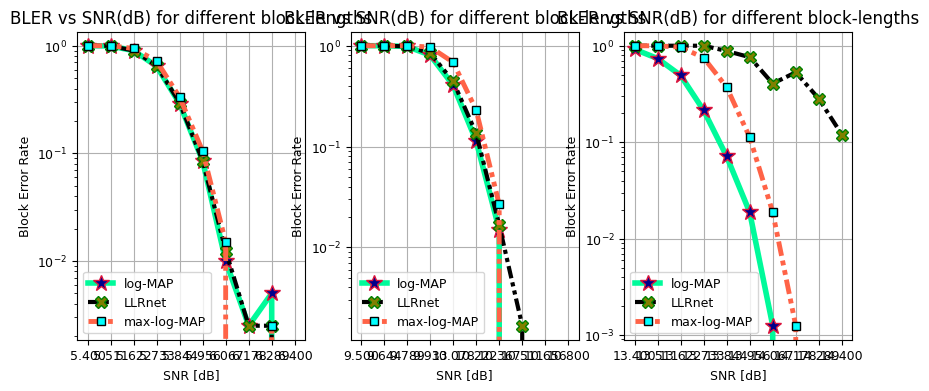

In [14]:
fig, ax = plt.subplots(1,3, figsize = (10,4))

# BLER for QAM-16
ax[0].semilogy(SNRdB[0], BLER[0,0], 'mediumspringgreen', lw = 4, linestyle = "solid", marker = "*", ms = 12, mec = "crimson", mfc = "darkblue", label = "log-MAP")
ax[0].semilogy(SNRdB[0], BLER[2,0], 'k', lw = 3, linestyle = (0, (3, 1, 1, 1, 1, 1)), marker = "X", ms = 9, mec = "green", mfc = "olive", label = "LLRnet")
ax[0].semilogy(SNRdB[0], BLER[1,0], 'tomato', lw = 3.5, linestyle = (0, (3, 1, 1, 1, 1, 1)), marker = "s", ms = 6, mec = "k", mfc = "cyan", label = "max-log-MAP")

ax[0].legend(loc="lower left")
ax[0].set_xlabel("SNR [dB]", fontsize = 9)
ax[0].set_ylabel("Block Error Rate", fontsize = 9)
ax[0].set_title("BLER vs SNR(dB) for different block-lengths", fontsize = 12)
ax[0].set_xticks(SNRdB[0])
ax[0].grid()

# BER for QAM-64
ax[1].semilogy(SNRdB[1], BLER[0,1], 'mediumspringgreen', lw = 4, linestyle = "solid", marker = "*", ms = 12, mec = "crimson", mfc = "darkblue", label = "log-MAP")
ax[1].semilogy(SNRdB[1], BLER[2,1], 'k', lw = 3, linestyle = (0, (3, 1, 1, 1, 1, 1)), marker = "X", ms = 9, mec = "green", mfc = "olive", label = "LLRnet")
ax[1].semilogy(SNRdB[1], BLER[1,1], 'tomato', lw = 3.5, linestyle = (0, (3, 1, 1, 1, 1, 1)), marker = "s", ms = 6, mec = "k", mfc = "cyan", label = "max-log-MAP")

ax[1].legend(loc="lower left")
ax[1].set_xlabel("SNR [dB]", fontsize = 9)
ax[1].set_ylabel("Block Error Rate", fontsize = 9)
ax[1].set_title("BLER vs SNR(dB) for different block-lengths", fontsize = 12)
ax[1].set_xticks(SNRdB[1])
ax[1].grid()

# BER for QAM-256
ax[2].semilogy(SNRdB[2], BLER[0,2], 'mediumspringgreen', lw = 4, linestyle = "solid", marker = "*", ms = 12, mec = "crimson", mfc = "darkblue", label = "log-MAP")
ax[2].semilogy(SNRdB[2], BLER[2,2], 'k', lw = 3, linestyle = (0, (3, 1, 1, 1, 1, 1)), marker = "X", ms = 9, mec = "green", mfc = "olive", label = "LLRnet")
ax[2].semilogy(SNRdB[2], BLER[1,2], 'tomato', lw = 3.5, linestyle = (0, (3, 1, 1, 1, 1, 1)), marker = "s", ms = 6, mec = "k", mfc = "cyan", label = "max-log-MAP")

ax[2].legend(loc="lower left")
ax[2].set_xlabel("SNR [dB]", fontsize = 9)
ax[2].set_ylabel("Block Error Rate", fontsize = 9)
ax[2].set_title("BLER vs SNR(dB) for different block-lengths", fontsize = 12)
ax[2].set_xticks(SNRdB[2])
ax[2].grid()

plt.rcParams.update({'font.size': 9})
plt.show()

## Performance Evaluation: 10000 batches and 64000 training samples for LLRNet
### Throughput vs SNR (dB) for 16-QAM, 64-QAM and, 256-QAM.

In [15]:
dB         = np.load("Database/AggregatedDatabase.npz")
SNRdB      = dB["SNRdB"]
BER        = dB["BER"]
BLER       = dB["BLER"]
Throughput = dB["Throughput"]

In [16]:

fig, ax = plt.subplots(1,3, figsize = (10,4))

# For 16-QAM
#********************************************
ax[0].plot(SNRdB[0], Throughput[0,0]/10**6, 'mediumspringgreen', lw = 4, linestyle = "solid", marker = "*", ms = 12, mec = "crimson", mfc = "darkblue", label = "log-MAP")
ax[0].plot(SNRdB[0], Throughput[2,0]/10**6, 'k', lw = 3, linestyle = (0, (3, 1, 1, 1, 1, 1)), marker = "X", ms = 9, mec = "green", mfc = "olive", label = "LLRnet")
ax[0].plot(SNRdB[0], Throughput[1,0]/10**6, 'tomato', lw = 3.5, linestyle = "dotted", marker = "s", ms = 6, mec = "k", mfc = "cyan", label = "max-log-MAP")

ax[0].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[0].legend(loc="lower right")
ax[0].set_xlabel("SNR [dB]", fontsize = 9)
ax[0].set_ylabel("Throughput (Mbps)", fontsize = 9)
ax[0].set_title("Throughput vs SNR(dB)", fontsize = 12)
ax[0].set_ylim(0, maxThroughput[2]/10**6)
ax[0].set_xticks(SNRdB[0])



plt.rcParams.update({'font.size': 9})
ax[0].grid()

# For 64-QAM
#********************************************
ax[1].plot(SNRdB[1,0:8], Throughput[0,1,0:8]/10**6, 'mediumspringgreen', lw = 4, linestyle = "solid", marker = "*", ms = 12, mec = "crimson", mfc = "darkblue", label = "log-MAP")
ax[1].plot(SNRdB[1,0:8], Throughput[2,1,0:8]/10**6, 'k', lw = 3, linestyle = (0, (3, 1, 1, 1, 1, 1)), marker = "X", ms = 9, mec = "green", mfc = "olive", label = "LLRnet")
ax[1].plot(SNRdB[1,0:8], Throughput[1,1,0:8]/10**6, 'tomato', lw = 3.5, linestyle = "dotted", marker = "s", ms = 6, mec = "k", mfc = "cyan", label = "max-log-MAP")

ax[1].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[1].legend(loc="lower right")
ax[1].set_xlabel("SNR [dB]", fontsize = 9)
ax[1].set_title("Throughput vs SNR(dB)", fontsize = 12)
ax[1].set_ylim(0, maxThroughput[2]/10**6)
ax[1].set_xticks(SNRdB[1,0:8])


plt.rcParams.update({'font.size': 9})
ax[1].grid()


# For 256-QAM
#********************************************

ax[2].plot(SNRdB[2,0:8], Throughput[0,2,0:8]/10**6, 'mediumspringgreen', lw = 4, linestyle = "solid", marker = "*", ms = 12, mec = "crimson", mfc = "darkblue", label = "log-MAP")
ax[2].plot(SNRdB[2,0:8], Throughput[2,2,0:8]/10**6, 'k', lw = 3, linestyle = (0, (3, 1, 1, 1, 1, 1)), marker = "X", ms = 9, mec = "green", mfc = "olive", label = "LLRnet")
ax[2].plot(SNRdB[2,0:8], Throughput[1,2,0:8]/10**6, 'tomato', lw = 3.5, linestyle = "dotted", marker = "s", ms = 6, mec = "k", mfc = "cyan", label = "max-log-MAP")

ax[2].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[2].legend(loc="lower right")
ax[2].set_xlabel("SNR [dB]", fontsize = 9)
ax[2].set_ylim(0, maxThroughput[2]/10**6)
ax[2].set_xticks(SNRdB[2,0:8])

# Adding Twin Axes to plot using dataset_2
axr = ax[2].twinx()
 
axr.set_ylabel('Throughput [%]')
# axr.plot(x, dataset_2, color = color)
axr.set_ylim(0, 100)

plt.rcParams.update({'font.size': 9})
ax[2].grid()

plt.show()

### Bit Error rate (BER) vs SNR (dB) for 16-QAM, 64-QAM and, 256-QAM.

* Comparison with:
    * max-log-MAP
    * log-MAP


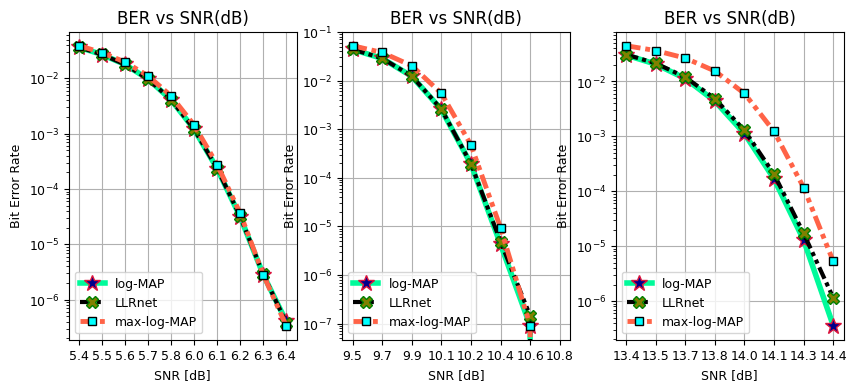

In [17]:
fig, ax = plt.subplots(1,3, figsize = (10,4))

# BER for QAM-16
ax[0].semilogy(SNRdB[0], BER[0,0], 'mediumspringgreen', lw = 4, linestyle = "solid", marker = "*", ms = 12, mec = "crimson", mfc = "darkblue", label = "log-MAP")
ax[0].semilogy(SNRdB[0], BER[2,0], 'k', lw = 3, linestyle = (0, (3, 1, 1, 1, 1, 1)), marker = "X", ms = 9, mec = "green", mfc = "olive", label = "LLRnet")
ax[0].semilogy(SNRdB[0], BER[1,0], 'tomato', lw = 3.5, linestyle = (0, (3, 1, 1, 1, 1, 1)), marker = "s", ms = 6, mec = "k", mfc = "cyan", label = "max-log-MAP")

ax[0].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[0].legend(loc="lower left")
ax[0].set_xlabel("SNR [dB]", fontsize = 9)
ax[0].set_ylabel("Bit Error Rate", fontsize = 9)
ax[0].set_title("BER vs SNR(dB)", fontsize = 12)
ax[0].set_xticks(SNRdB[0])
ax[0].grid()

# BER for QAM-64
ax[1].semilogy(SNRdB[1,0:8], BER[0,1,0:8], 'mediumspringgreen', lw = 4, linestyle = "solid", marker = "*", ms = 12, mec = "crimson", mfc = "darkblue", label = "log-MAP")
ax[1].semilogy(SNRdB[1,0:8], BER[2,1,0:8], 'k', lw = 3, linestyle = (0, (3, 1, 1, 1, 1, 1)), marker = "X", ms = 9, mec = "green", mfc = "olive", label = "LLRnet")
ax[1].semilogy(SNRdB[1,0:8], BER[1,1,0:8], 'tomato', lw = 3.5, linestyle = (0, (3, 1, 1, 1, 1, 1)), marker = "s", ms = 6, mec = "k", mfc = "cyan", label = "max-log-MAP")

ax[1].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[1].legend(loc="lower left")
ax[1].set_xlabel("SNR [dB]", fontsize = 9)
ax[1].set_ylabel("Bit Error Rate", fontsize = 9)
ax[1].set_title("BER vs SNR(dB)", fontsize = 12)
ax[1].set_xticks(SNRdB[1,0:8])
ax[1].grid()

# BER for QAM-256
ax[2].semilogy(SNRdB[2,0:8], BER[0,2,0:8], 'mediumspringgreen', lw = 4, linestyle = "solid", marker = "*", ms = 12, mec = "crimson", mfc = "darkblue", label = "log-MAP")
ax[2].semilogy(SNRdB[2,0:8], BER[2,2,0:8], 'k', lw = 3, linestyle = (0, (3, 1, 1, 1, 1, 1)), marker = "X", ms = 9, mec = "green", mfc = "olive", label = "LLRnet")
ax[2].semilogy(SNRdB[2,0:8], BER[1,2,0:8], 'tomato', lw = 3.5, linestyle = (0, (3, 1, 1, 1, 1, 1)), marker = "s", ms = 6, mec = "k", mfc = "cyan", label = "max-log-MAP")

ax[2].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[2].legend(loc="lower left")
ax[2].set_xlabel("SNR [dB]", fontsize = 9)
ax[2].set_ylabel("Bit Error Rate", fontsize = 9)
ax[2].set_title("BER vs SNR(dB)", fontsize = 12)
ax[2].set_xticks(SNRdB[2,0:8])
ax[2].grid()

plt.rcParams.update({'font.size': 9})

plt.show()

### Block Error rate (BER) vs SNR (dB) for 16-QAM, 64-QAM and, 256-QAM.

* Comparison with:
    * max-log-MAP
    * log-MAP


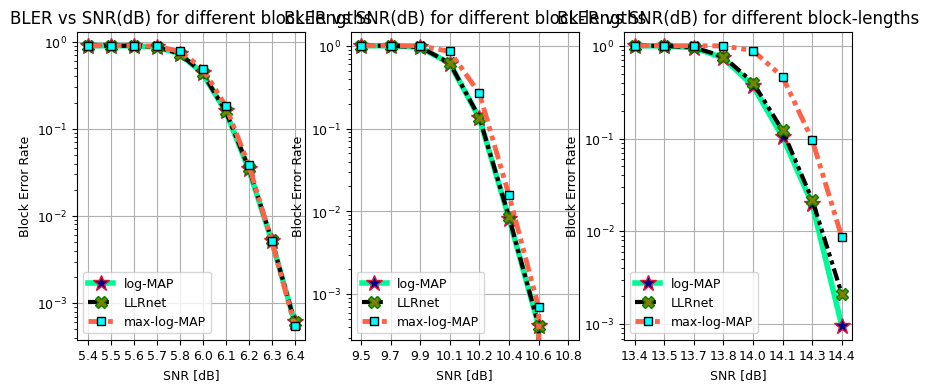

In [18]:
fig, ax = plt.subplots(1,3, figsize = (10,4))

# BLER for QAM-16
ax[0].semilogy(SNRdB[0], BLER[0,0], 'mediumspringgreen', lw = 4, linestyle = "solid", marker = "*", ms = 12, mec = "crimson", mfc = "darkblue", label = "log-MAP")
ax[0].semilogy(SNRdB[0], BLER[2,0], 'k', lw = 3, linestyle = (0, (3, 1, 1, 1, 1, 1)), marker = "X", ms = 9, mec = "green", mfc = "olive", label = "LLRnet")
ax[0].semilogy(SNRdB[0], BLER[1,0], 'tomato', lw = 3.5, linestyle = (0, (3, 1, 1, 1, 1, 1)), marker = "s", ms = 6, mec = "k", mfc = "cyan", label = "max-log-MAP")

ax[0].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[0].legend(loc="lower left")
ax[0].set_xlabel("SNR [dB]", fontsize = 9)
ax[0].set_ylabel("Block Error Rate", fontsize = 9)
ax[0].set_title("BLER vs SNR(dB) for different block-lengths", fontsize = 12)
ax[0].set_xticks(SNRdB[0])
ax[0].grid()

# BER for QAM-64
ax[1].semilogy(SNRdB[1,0:8], BLER[0,1,0:8], 'mediumspringgreen', lw = 4, linestyle = "solid", marker = "*", ms = 12, mec = "crimson", mfc = "darkblue", label = "log-MAP")
ax[1].semilogy(SNRdB[1,0:8], BLER[2,1,0:8], 'k', lw = 3, linestyle = (0, (3, 1, 1, 1, 1, 1)), marker = "X", ms = 9, mec = "green", mfc = "olive", label = "LLRnet")
ax[1].semilogy(SNRdB[1,0:8], BLER[1,1,0:8], 'tomato', lw = 3.5, linestyle = (0, (3, 1, 1, 1, 1, 1)), marker = "s", ms = 6, mec = "k", mfc = "cyan", label = "max-log-MAP")

ax[1].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[1].legend(loc="lower left")
ax[1].set_xlabel("SNR [dB]", fontsize = 9)
ax[1].set_ylabel("Block Error Rate", fontsize = 9)
ax[1].set_title("BLER vs SNR(dB) for different block-lengths", fontsize = 12)
ax[1].set_xticks(SNRdB[1,0:8])
ax[1].grid()

# BER for QAM-256
ax[2].semilogy(SNRdB[2,0:8], BLER[0,2,0:8], 'mediumspringgreen', lw = 4, linestyle = "solid", marker = "*", ms = 12, mec = "crimson", mfc = "darkblue", label = "log-MAP")
ax[2].semilogy(SNRdB[2,0:8], BLER[2,2,0:8], 'k', lw = 3, linestyle = (0, (3, 1, 1, 1, 1, 1)), marker = "X", ms = 9, mec = "green", mfc = "olive", label = "LLRnet")
ax[2].semilogy(SNRdB[2,0:8], BLER[1,2,0:8], 'tomato', lw = 3.5, linestyle = (0, (3, 1, 1, 1, 1, 1)), marker = "s", ms = 6, mec = "k", mfc = "cyan", label = "max-log-MAP")

ax[2].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[2].legend(loc="lower left")
ax[2].set_xlabel("SNR [dB]", fontsize = 9)
ax[2].set_ylabel("Block Error Rate", fontsize = 9)
ax[2].set_title("BLER vs SNR(dB) for different block-lengths", fontsize = 12)
ax[2].set_xticks(SNRdB[2,0:8])
ax[2].grid()

plt.rcParams.update({'font.size': 9})
plt.show()

### Complexity Analysis

- Computational Complexity vs Throughput.
- Computational Complexity vs BER/BLER.
- Comparison with **max-log-MAP** and **log-MAP**.

**Note**: The throughput data used in following calculations is taken from the above simulations and the computational complexity number are provided by author in the paper. The complexity number for this paer may be slighlty different due to over configured model used for the simulation.

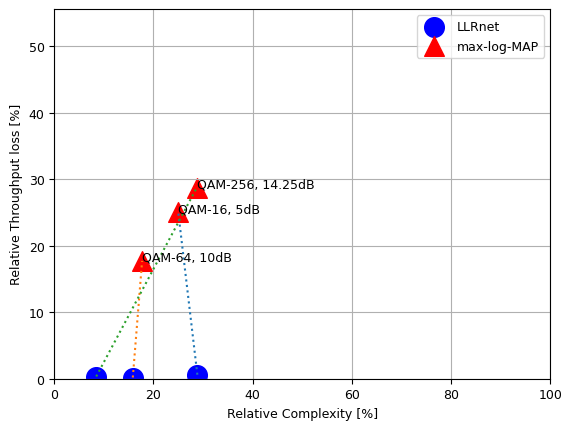

In [19]:
complexityLogMAP    = np.array([832, 3840, 17408])
complexityMaxLogMAP = np.array([208,  680,  5000])
complexityLLRnet    = np.array([240,  608,  1472])

normalizedComplexityMaxLogMAP = complexityMaxLogMAP/complexityLogMAP*100
normalizedComplexityLLRnet = complexityLLRnet/complexityLogMAP*100

throughPutLogMAP    = np.array([28.2,  60.05, 90.4])  # @ SNR (dB) = 5
throughPutMaxLogMAP = np.array([24.75, 42.12, 49.2])  # @ SNR (dB) = 10
throughPutLLRnet    = np.array([28.03, 59.94, 90.1])  # @ SNR (dB) = 14.25

normalizedThroughPutMaxLogMAP = (1-throughPutMaxLogMAP/throughPutLogMAP)*100
normalizedThroughPutLLRnet    = (1-throughPutLLRnet/throughPutLogMAP)*100
SNRdBValues = [5, 10, 14.25]
modOrder    = [16,64,256]

fig, ax = plt.subplots()

ax.scatter(normalizedComplexityLLRnet, normalizedThroughPutLLRnet, marker = 'o', edgecolors="blue", facecolors="blue", s = 200, label = "LLRnet")
ax.scatter(normalizedComplexityMaxLogMAP, normalizedComplexityMaxLogMAP, marker = '^', edgecolors="red", facecolors="red", s = 200, label = "max-log-MAP")
for i in range(3):
    plt.plot([normalizedComplexityLLRnet[i], normalizedComplexityMaxLogMAP[i]], [normalizedThroughPutLLRnet[i], normalizedComplexityMaxLogMAP[i]], ':')
    plt.text(normalizedComplexityMaxLogMAP[i], normalizedComplexityMaxLogMAP[i],"QAM-"+str(modOrder[i])+", "+str(SNRdBValues[i])+"dB")
    
ax.set_xlabel("Relative Complexity [%]")
ax.set_ylabel("Relative Throughput loss [%]")
ax.set_xlim(0,100)
ax.set_ylim(0,normalizedThroughPutMaxLogMAP.max()+10)
ax.grid()
ax.legend()
plt.show()

## Conclusion
Now that we have understood **LLRnet**, we are in a position to discuss the positives and the limitations of this model. 

### Positives of the LLRnet:
The positive of using LLRnet for decoding/demapping the equalized symbols are:

* Low complexity and requires few samples for training.
* Not impractical to train even online in real-time for demapping.


### Limitations of the LLRnet:
On the other hand there are a few limitations of the techniques:

* **Robustness**: 
    * Performance is sensitive to estimate of SNR available.
* **Generalization**: 
    * Different models are required for different modulation orders.
    * Not generalized for all the SNRs.
* **Power consumption vs Cost**: 
    * Deployment of multiple models (for different modulation order and SNR) is computationally efficient but occupy large silicon (**Si**) space on FPGA or SoC.
    * Larger the silicon required, higher the cost and bulkier the device.

## References:

- O. Shental and J. Hoydis, [""Machine LLRning": Learning to Softly Demodulate,"](https://arxiv.org/pdf/1907.01512.pdf) 2019 IEEE Globecom Workshops (GC Wkshps), Waikoloa, HI, USA, 2019, pp. 1-7, doi: 10.1109/GCWkshps45667.2019.9024433.
- Python code for [LLRNet](llrNet.py).